# Exploration of LIMEtree explanations

In [1]:
import os

_base_path = ('https://raw.githubusercontent.com/fat-forensics/resources/'
              'master/surrogates_overview/scripts/{}')
_scripts = ['__init__.py', 'image_classifier.py', 'imagenet_label_map.py']
! mkdir -p scripts
for i in _scripts:
    i_ = _base_path.format(i)
    if not os.path.exists(f'scripts/{i}'):
        ! wget $i_ -O scripts/$i

if not os.path.exists('scripts/helpers.py'):
    ! cp ../DAMI_2021/helpers.py scripts/

! mkdir -p _figures

In [2]:
# NBVAL_IGNORE_OUTPUT
import fatf

import fatf.utils.data.instance_augmentation as fatf_augmentation
import fatf.utils.models.processing as fatf_processing

import fatf.utils.data.segmentation as fatf_segmentation
import fatf.utils.data.occlusion as fatf_occlusion

import scripts.image_classifier as imgclf

from scripts.helpers import plot_bar_exp

from scripts.limetree import (
    imshow, visualise_img,
    tree_to_code, rules_dict2array, rules_dict2list,
    tree_get_explanation, filter_explanations)

22-Sep-02 16:24:38 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [3]:
import itertools

import sklearn.linear_model
import sklearn.tree

from PIL import Image

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('text', usetex=True)
plt.style.use('seaborn')  # 'classic'

In [4]:
IDS = {
    'tennis ball': 852,
    'golden retriever': 207,
    'Labrador retriever': 208
}

def find_dog_prediction(tuple_list):
    classes = tuple(IDS.keys())
    return [i for i in tuple_list if i[0] in classes]

In [5]:
dog = Image.open('img/dog_ball.jpg')
dog_array = np.asarray(dog)

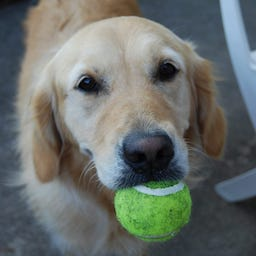

In [6]:
dog

In [7]:
clf = imgclf.ImageClassifier()

clf.proba2tuple(
    clf.predict_proba([dog_array]),
    labels_no=5
)

/Users/kacper/.pyenv/versions/3.8.13/envs/limetree/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/kacper/.pyenv/versions/3.8.13/envs/limetree/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/kacper/.pyenv/versions/3.8.13/envs/limetree/lib/python3.8/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may 

[[('tennis ball', 0.99284875, 852),
  ('golden retriever', 0.0067028664, 207),
  ('Labrador retriever', 0.00043766573, 208),
  ('racket', 4.7027543e-06, 752),
  ('Chesapeake Bay retriever', 2.9818214e-06, 209)]]

## Segmentation

### Default

In [8]:
fatf.setup_random_seed(42)

segmenter = fatf_segmentation.QuickShift(
    dog_array,
    ratio=0.4,
    kernel_size=5,
    max_dist=50)

22-Sep-02 16:24:39 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-02 16:24:39 fatf         INFO     Seeding RNGs with 42.


In [9]:
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 32


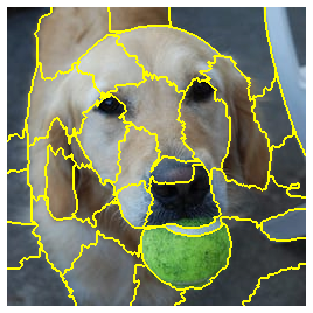

In [10]:
dog_segmented_default = segmenter.mark_boundaries(colour=(255, 255, 0))

imshow(dog_segmented_default)

In [11]:
plt.imsave('_figures/dog_segments_default.jpeg', dog_segmented_default)

### Custom

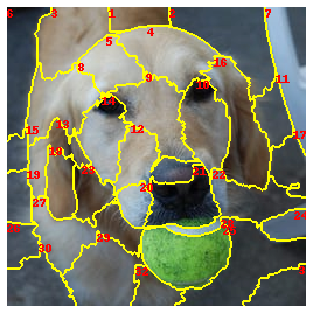

In [12]:
imshow(segmenter.number_segments(
    image=dog_segmented_default, colour=(255, 0, 0)))

In [13]:
dog_segment_merge = [                   # RETRIEVER
    [25],                               # ball
    [14],                               # left eye
    [10],                               # right eye
    [21],                               # nose
    [4, 5, 9, 12, 16, 20],              # face
    [1, 3, 8, 13, 18, 23, 27, 29, 32],  # body
    [6, 15, 19, 26, 30],                # left bg
    [2, 7, 11, 17, 22, 24, 28, 31]      # right bg
]

_ = segmenter.merge_segments(dog_segment_merge, inplace=True)
segmenter.segments_number = len(dog_segment_merge)
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 8


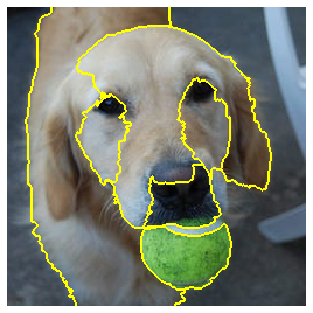

In [14]:
dog_segmented_custom = segmenter.mark_boundaries(colour=(255, 255, 0))

imshow(dog_segmented_custom)

In [15]:
plt.imsave('_figures/dog_segments_custom.jpeg', dog_segmented_custom)

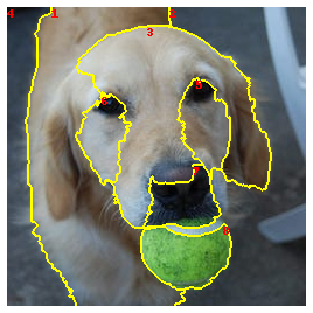

In [16]:
imshow(segmenter.number_segments(
    image=dog_segmented_custom, colour=(255, 0, 0)))

## Surrogate Explanations

In [17]:
SAMPLES_NO = 1000
GENERATE_FULL_SAMPLE = True

BATCH_SIZE = 100

OCCLUSION_COLOUR = 'black'

GET_TOP_N = 4

In [18]:
# Get occluder with the desired colour
occluder = fatf_occlusion.Occlusion(
    dog_array, segmenter.segments, colour=OCCLUSION_COLOUR)

# Generate sample
if GENERATE_FULL_SAMPLE:
    sampled_data = np.array(list(itertools.product(
        [0, 1], repeat=segmenter.segments_number)))
else:
    fatf.setup_random_seed(42)
    sampled_data = fatf_augmentation.random_binary_sampler(
        segmenter.segments_number, SAMPLES_NO)

# Convert to images and predict (in batches)
iter_ = fatf_processing.batch_data(
    sampled_data,
    batch_size=BATCH_SIZE,
    transformation_fn=occluder.occlude_segments_vectorised)

sampled_data_probabilities = []
for batch in iter_:
    sampled_data_probabilities.append(
        clf.predict_proba(batch))
sampled_data_probabilities = np.vstack(sampled_data_probabilities)

## Linear Surrogate Explanation

In [19]:
# Get linear explanation
def get_linear(class_id, top_features=None):
    class_probs = sampled_data_probabilities[:, class_id]

    model = sklearn.linear_model.Ridge(
        alpha=1, fit_intercept=True, random_state=42)
    model.fit(sampled_data, class_probs)  # sample_weight

    feature_ordering = np.flip(np.argsort(np.abs(model.coef_)))
    if top_features is None:
        top_features = feature_ordering
    else:
        top_features = feature_ordering[:top_features]
    # Add 1 since segment count starts at 1 and not at 0
    top_features_ = top_features + 1

    explanation = list(zip(top_features_, model.coef_[top_features]))

    return model, explanation

### Tennis Ball

In [20]:
class_name = 'tennis ball'
model, explanation = get_linear(IDS[class_name])
explanation_sorted = map(lambda x: x[1], sorted(explanation, key=lambda x: x[0]))

explanation

[(8, 0.7057780083708798),
 (7, 0.19203819844417294),
 (2, 0.10045357729521551),
 (3, 0.09911704659078589),
 (4, 0.06168752230788904),
 (1, 0.039990808495237555),
 (6, -0.017516480335605315),
 (5, -0.011010996956219272)]

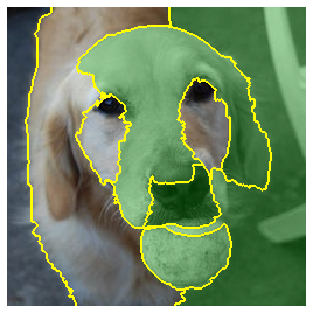

In [21]:
explanation_overlay = visualise_img(explanation, segmenter, top_features=GET_TOP_N)

imshow(explanation_overlay)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_overlay)

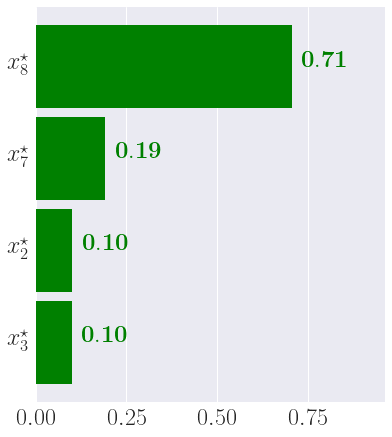

In [22]:
# fontsize=14 # labelsize=16
# xlim = (-0.001, 0.017) # xlim = (-0.01, 0.76)
plot_bar_exp(
    explanation_sorted,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf')

### Golden Retriever

In [23]:
class_name = 'golden retriever'
model, explanation = get_linear(IDS[class_name])
explanation_sorted = map(lambda x: x[1], sorted(explanation, key=lambda x: x[0]))

explanation

[(1, 0.21038658711150515),
 (3, 0.2006514905554099),
 (8, -0.19208454693702348),
 (5, 0.07723896578074564),
 (7, -0.055410574403269616),
 (6, 0.05035196168629034),
 (4, 0.03851033176032047),
 (2, -0.0011750326184989835)]

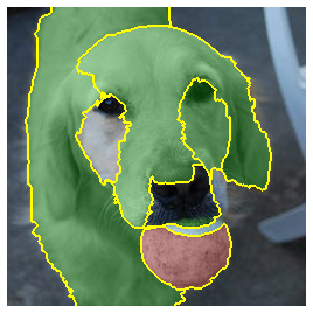

In [24]:
explanation_overlay = visualise_img(explanation, segmenter, top_features=GET_TOP_N)

imshow(explanation_overlay)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_overlay)

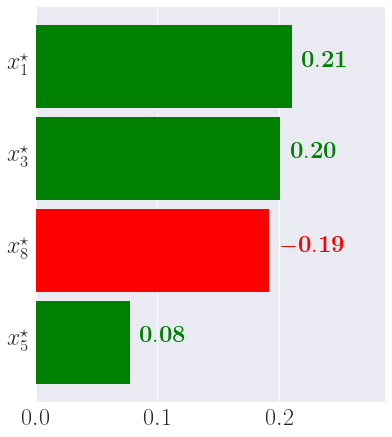

In [25]:
plot_bar_exp(
    explanation_sorted,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf')

### Labrador Retriever

In [26]:
class_name = 'Labrador retriever'
model, explanation = get_linear(IDS[class_name])
explanation_sorted = map(lambda x: x[1], sorted(explanation, key=lambda x: x[0]))

explanation

[(8, -0.18189106739539662),
 (3, 0.12910918479148556),
 (2, -0.06224082945163871),
 (6, 0.05399872846326714),
 (5, 0.03123644124749474),
 (1, -0.023680065555051706),
 (7, 0.009764682862417773),
 (4, 0.0030087470955290603)]

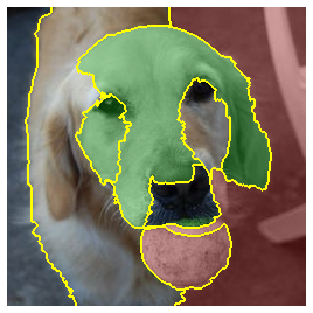

In [27]:
explanation_overlay = visualise_img(explanation, segmenter, top_features=GET_TOP_N)

imshow(explanation_overlay)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_overlay)

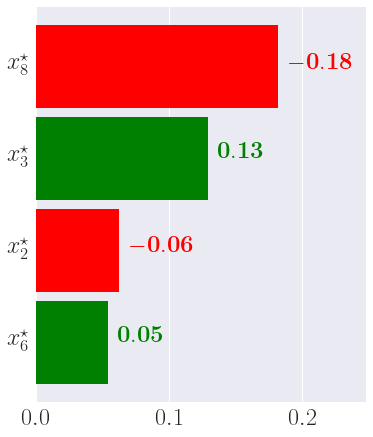

In [28]:
plot_bar_exp(
    explanation_sorted,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf')

## Tree Surrogate Explanation

In [29]:
# Get tree explanation
def get_tree(class_ids, tree_params=None):
    if tree_params is None: tree_params = dict()
    class_probs = sampled_data_probabilities[:, class_ids]

    model = sklearn.tree.DecisionTreeRegressor(random_state=42, **tree_params)
    model.fit(sampled_data, class_probs)  # sample_weight

    return model

In [30]:
classes_sorted = sorted(IDS.items(), key=lambda x: x[1])
classes_names = [i[0] for i in classes_sorted]
classes_ids = [i[1] for i in classes_sorted]

feature_names = [f'\\(x_{{{i+1:d}}}^\star\\)'
                 for i in range(segmenter.segments_number)]
feature_names_ = [f'x{i+1:d}' for i in range(segmenter.segments_number)]

In [31]:
# Full tree
tree_multi = get_tree(classes_ids)

The depth is: 8


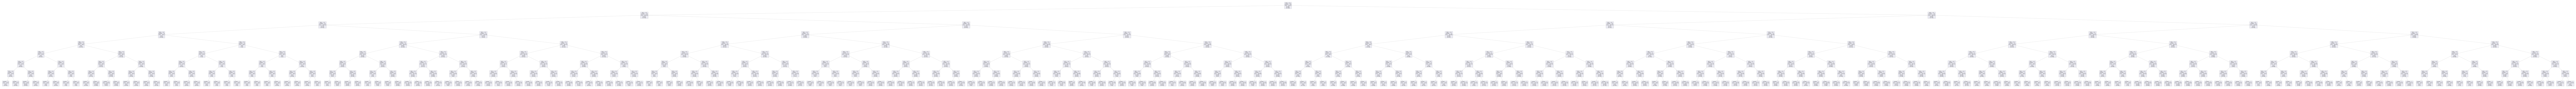

In [32]:
print(f'The depth is: {tree_multi.get_depth()}')

plt.figure(figsize=(512, 18))
_ = sklearn.tree.plot_tree(
    tree_multi,
    fontsize=12,
    # filled=True,
    node_ids=False,
    # label='all',
    impurity=False)

### Tree Visualisation -- Toy Tree

In [33]:
# Toy tree
tree_params = dict(
    # max_leaf_nodes=5,
    max_depth=2,
    # max_leaf_nodes=4,
    # min_impurity_decrease=0.01
)
tree_multi_2 = get_tree(classes_ids, tree_params)

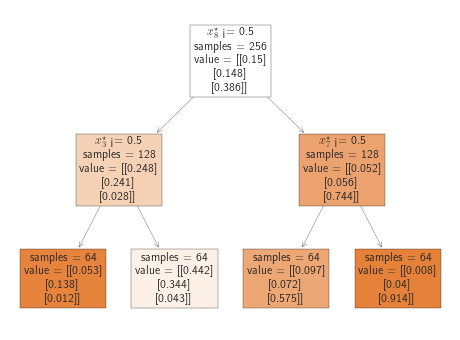

In [34]:
plt.figure(figsize=(8, 6))
_ = sklearn.tree.plot_tree(
    tree_multi_2,
    feature_names=feature_names,
    class_names=classes_names,
    fontsize=12,
    filled=True,
    node_ids=False,
    label='all',
    impurity=False)

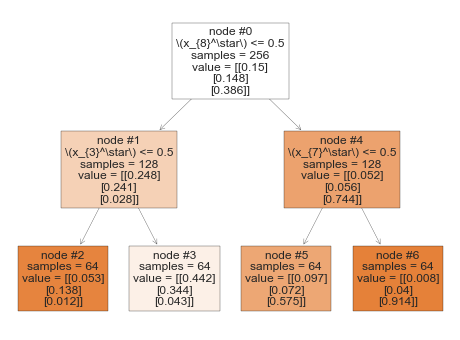

In [35]:
matplotlib.rc('text', usetex=False)
plt.figure(figsize=(8, 6))
_ = sklearn.tree.plot_tree(
    tree_multi_2,
    feature_names=feature_names,
    class_names=classes_names,
    fontsize=12,
    filled=True,
    node_ids=True,
    label='all',
    impurity=False)
matplotlib.rc('text', usetex=True)

In [36]:
tree_to_code(tree_multi_2, feature_names=feature_names_)

{0: {},
 1: {'x8': 0},
 2: {'x8': 0, 'x3': 0, 'prediction': array([[0.05313914],
         [0.13773106],
         [0.01187093]])},
 3: {'x8': 0,
  'x3': 1,
  'prediction': array([[0.44200412],
         [0.3436977 ],
         [0.04340575]])},
 4: {'x8': 1},
 5: {'x8': 1,
  'x7': 0,
  'prediction': array([[0.09733146],
         [0.07214243],
         [0.57537959]])},
 6: {'x8': 1,
  'x7': 1,
  'prediction': array([[0.00764007],
         [0.0398201 ],
         [0.91350866]])}}

In [37]:
tree_multi_2_code = tree_to_code(
    tree_multi_2, feature_number=segmenter.segments_number)
tree_multi_2_list = rules_dict2list(
    tree_multi_2_code, segmenter.segments_number)
tree_multi_2_list

{0: {'off': [], 'on': [], 'none': [1, 2, 3, 4, 5, 6, 7, 8]},
 1: {'off': [8], 'on': [], 'none': [1, 2, 3, 4, 5, 6, 7]},
 2: {'off': [8, 3],
  'on': [],
  'none': [1, 2, 4, 5, 6, 7],
  'prediction': array([[0.05313914],
         [0.13773106],
         [0.01187093]])},
 3: {'off': [8],
  'on': [3],
  'none': [1, 2, 4, 5, 6, 7],
  'prediction': array([[0.44200412],
         [0.3436977 ],
         [0.04340575]])},
 4: {'off': [], 'on': [8], 'none': [1, 2, 3, 4, 5, 6, 7]},
 5: {'off': [7],
  'on': [8],
  'none': [1, 2, 3, 4, 5, 6],
  'prediction': array([[0.09733146],
         [0.07214243],
         [0.57537959]])},
 6: {'off': [],
  'on': [8, 7],
  'none': [1, 2, 3, 4, 5, 6],
  'prediction': array([[0.00764007],
         [0.0398201 ],
         [0.91350866]])}}

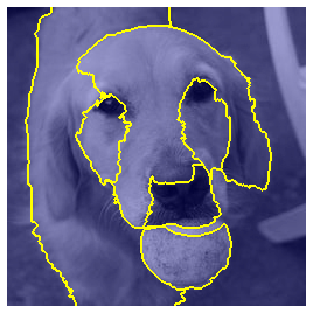

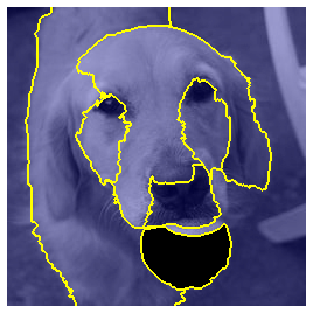

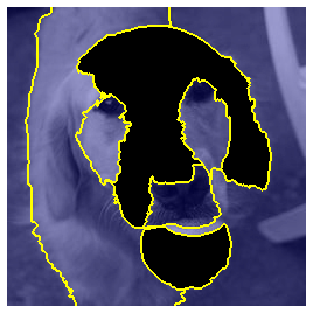

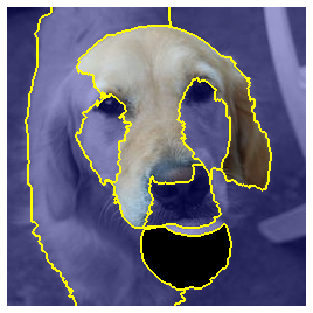

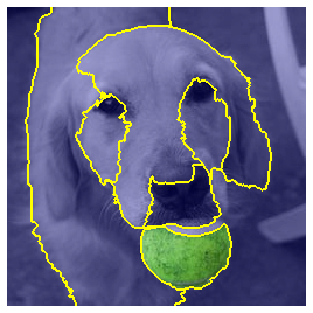

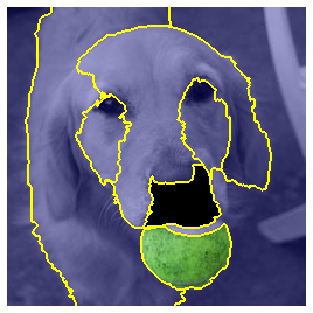

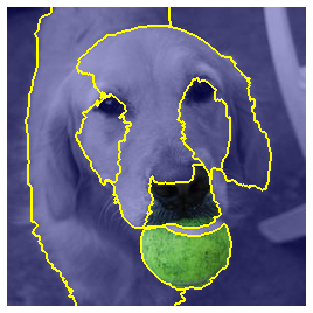

In [38]:
highlight_colours = dict(none=(0, 0, 255), on=None, off=(0, 0, 0))

for node_id, pattern in tree_multi_2_list.items():
    # Highlight none
    node_highlight = segmenter.highlight_segments(
        pattern['none'], colour=highlight_colours['none'])
    # leave on
    # Occlude off
    node_highlight = occluder.occlude_segments(
        pattern['off'], image=node_highlight)
    # highlight boundaries
    node_highlight_ = segmenter.mark_boundaries(
        image=node_highlight, colour=(255, 255, 0))

    imshow(node_highlight_)

    plt.imsave(f'_figures/explanation_limetree_multi-tree-node{node_id}.pdf',  # jpeg
               node_highlight_)

### Feature Importance -- Full Tree

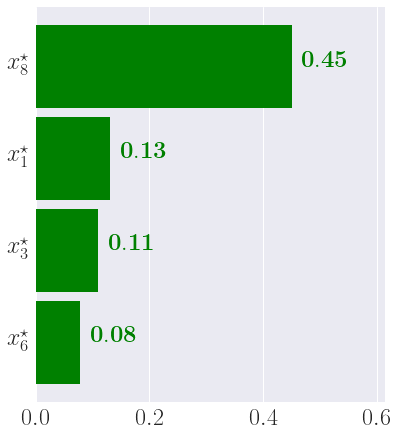

In [39]:
plot_bar_exp(
    tree_multi.feature_importances_,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_limetree_multi-bar.pdf')

### What-If Explanation -- Full Tree

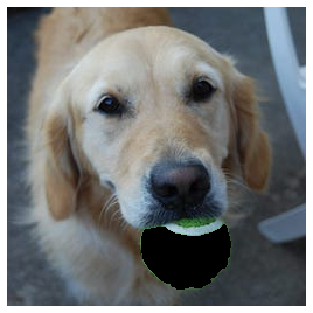

In [40]:
# What if the ball (#8) was not there?
segment_id_ball = 8

dog_sans_ball = occluder.occlude_segments(segment_id_ball)

imshow(dog_sans_ball)

plt.imsave(f'_figures/explanation_limetree_multi-tree_whatif-ball.pdf',  # jpeg
            dog_sans_ball)

In [41]:
clf.proba2tuple(
    clf.predict_proba([dog_sans_ball]),
    labels_no=5
)

[[('golden retriever', 0.96582496, 207),
  ('Labrador retriever', 0.022743592, 208),
  ('tennis ball', 0.011067294, 852),
  ('Chesapeake Bay retriever', 4.83455e-05, 209),
  ('flat-coated retriever', 3.641526e-05, 205)]]

In [42]:
dog_sans_ball_binary = np.ones(segmenter.segments_number, dtype=np.int16)
dog_sans_ball_binary[segment_id_ball - 1] = 0

list(zip(classes_names,
         tree_multi.predict([dog_sans_ball_binary])[0]))

[('golden retriever', 0.9658248424530029),
 ('Labrador retriever', 0.022743457928299904),
 ('tennis ball', 0.01106751337647438)]

### Exemplar Explanation (1) -- Full Tree

In [43]:
class_id = 1

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=True,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->Labrador retriever<-
[0.48956783255562186, 0.5389271974563599, 0.49126186221838, 0.4279865026473999, 0.6105432510375977, 0.7287020087242126, 0.49238449335098267, 0.6141257770359516, 0.6084227487444878, 0.5732984989881516, 0.7512279748916626, 0.643546998500824, 0.8004288673400879, 0.48666512966156006, 0.6198288053274155, 0.5128830671310425, 0.44448184967041016, 0.5812842845916748, 0.7267745435237885, 0.8716530203819275, 0.5818960666656494, 0.48436305779796385, 0.6861998438835144, 0.9236815571784973, 0.5917535442858934, 0.7175445705652237, 0.49382469058036804, 0.9412644505500793, 0.751312181353569, 0.7257064580917358, 0.7526116371154785, 0.6988012790679932, 0.7769179046154022, 0.7160794138908386, 0.8377563953399658, 0.5648960465332493, 0.8147158399224281, 0.6621082723140717, 0.5140037536621094, 0.48806458711624146, 0.5399429202079773, 0.8102127909660339, 0.8387007117271423, 0.7817248702049255, 0.9673234075307846, 0.9816814363002777, 0.9794403910636902, 0.9839224815368

Probability of class ->Labrador retriever<-: 0.582


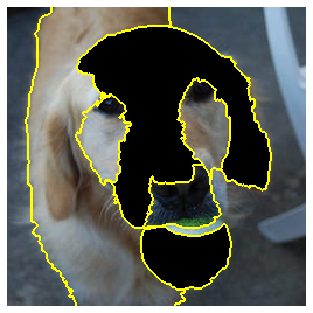

In [44]:
vis_id = 20

print(f'Probability of class ->{classes_names[class_id]}<-: '
      f'{class_prediction[vis_id]:.3f}')

# Highlight none
if image_spec[vis_id]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[vis_id]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[vis_id]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[vis_id]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-example{class_id}.pdf',  # jpeg
            example_highlight_)

### Exemplar Explanation (2) -- Full Tree

In [45]:
class_id = 0

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=True,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->golden retriever<-
[0.4420041230462175, 0.3859806216787547, 0.530047107487917, 0.8672900497913361, 0.8538188338279724, 0.8807612657546997, 0.45358146727085114, 0.461804062128067, 0.44535887241363525, 0.7368093925761059, 0.5551193302962929, 0.45385444164276123, 0.40621137619018555, 0.5014975070953369, 0.8168925978243351, 0.7210346236824989, 0.5937701612710953, 0.7215080857276917, 0.8482990860939026, 0.9003058671951294, 0.7962923049926758, 0.9127505719661713, 0.9640211462974548, 0.9448198676109314, 0.9832224249839783, 0.8614799976348877, 0.7875946760177612, 0.9353653192520142, 0.9184994548559189, 0.899680957198143, 0.8813024014234543, 0.891834169626236, 0.8610853552818298, 0.9225829839706421, 0.8707706332206726, 0.8884616494178772, 0.853079617023468, 0.9180595129728317, 0.8725414872169495, 0.8768132925033569, 0.868269681930542, 0.963577538728714, 0.9796339869499207, 0.9475210905075073, 0.9373179525136948, 0.9135820865631104, 0.8699328005313873, 0.8621537685394287, 0.8

Probability of class ->golden retriever<-: 0.536


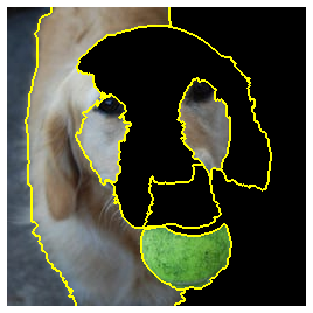

In [46]:
vis_id = 63

print(f'Probability of class ->{classes_names[class_id]}<-: '
      f'{class_prediction[vis_id]:.3f}')

# Highlight none
if image_spec[vis_id]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[vis_id]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[vis_id]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[vis_id]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-example{class_id}.pdf',  # jpeg
            example_highlight_)

### Shortest Explanations (x2?) -- Full Tree

In [47]:
class_id = 2

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=True,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->tennis ball<-
[0.5137028098106384, 0.9155585169792175, 0.9730100631713867]


Probability of class ->tennis ball<-: 0.514


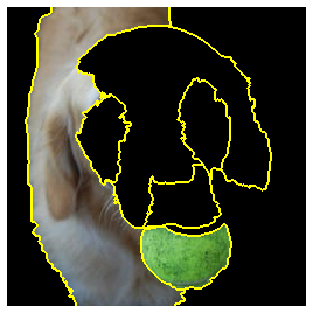

Probability of class ->tennis ball<-: 0.916


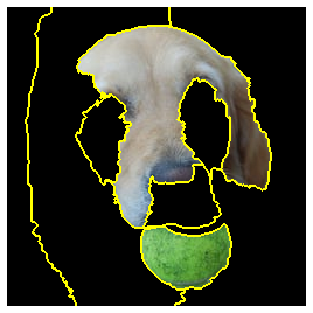

Probability of class ->tennis ball<-: 0.973


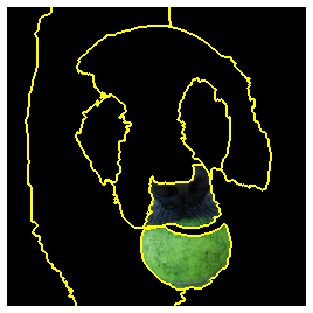

In [48]:
for vis_id in range(len(class_prediction)):
    print(f'Probability of class ->{classes_names[class_id]}<-: '
        f'{class_prediction[vis_id]:.3f}')

    # Highlight none
    if image_spec[vis_id]['none']:
        example_highlight = segmenter.highlight_segments(
            image_spec[vis_id]['none'], colour=highlight_colours['none'])
    else:
        example_highlight = segmenter.image.copy()
    # leave on
    # Occlude off
    if image_spec[vis_id]['off']:
        example_highlight = occluder.occlude_segments(
            image_spec[vis_id]['off'], image=example_highlight)
    else:
        example_highlight = example_highlight
    # highlight boundaries
    example_highlight_ = segmenter.mark_boundaries(
        image=example_highlight, colour=(255, 255, 0))

    imshow(example_highlight_)

    plt.imsave(f'_figures/explanation_limetree_multi-tree-shortest{class_id}-{vis_id}.pdf',  # jpeg
                example_highlight_)

### Rule Explanation -- Full Tree

In [49]:
class_id = 1

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=True,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction})')

Explaining class: ->Labrador retriever<- (0.9839224815368652)


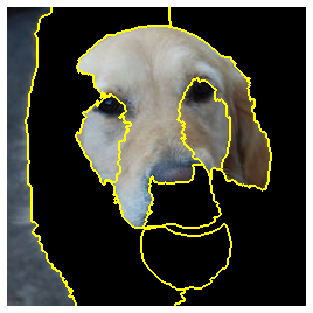

In [50]:
# Highlight none
if image_spec['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec['off']:
    example_highlight = occluder.occlude_segments(
        image_spec['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-rule{class_id}.pdf',  # jpeg
            example_highlight_)

### Customised Explanations x2 -- Full Tree

#### Preserve Ball and Get Golden Retriever

In [51]:
id_on = [segment_id_ball]
id_off = []

class_id = 0

In [52]:
class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->golden retriever<-
[0.8538188338279724, 0.8807612657546997, 0.461804062128067, 0.44535887241363525, 0.40621137619018555, 0.5014975070953369, 0.7215080857276917, 0.9003058671951294, 0.7962923049926758, 0.9448198676109314, 0.9832224249839783, 0.7875946760177612, 0.9353653192520142, 0.8610853552818298, 0.9225829839706421, 0.8884616494178772, 0.853079617023468, 0.8768132925033569, 0.868269681930542, 0.9796339869499207, 0.9475210905075073, 0.8621537685394287, 0.877711832523346, 0.9290463924407959, 0.9854163527488708, 0.9749266505241394, 0.9562138915061951, 0.9472498893737793, 0.9658248424530029, 0.3143637478351593, 0.45678868889808655, 0.5364792943000793]


In [53]:
on_off_idxs = filter_explanations(
    image_spec, on=id_on, off=id_off, use_none=False)

for i in on_off_idxs:
    print(f'{i}: {class_prediction[i]:.3f}\n    {image_spec[i]}')

29: 0.314
    {'off': [7, 3, 6, 2, 5], 'on': [8, 1, 4], 'none': []}
30: 0.457
    {'off': [7, 3, 2, 4], 'on': [8, 1, 6, 5], 'none': []}
31: 0.536
    {'off': [7, 3, 2], 'on': [8, 1, 6, 5, 4], 'none': []}


In [54]:
# Get argmax
idx = np.argmax([class_prediction[i] for i in on_off_idxs])
idx = on_off_idxs[idx]

class_prediction = class_prediction[idx]
image_spec = image_spec[idx]

Explaining class: ->golden retriever<- (0.5364792943000793)


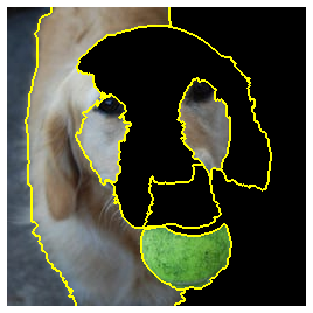

In [55]:
print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction})')

# Highlight none
if image_spec['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec['off']:
    example_highlight = occluder.occlude_segments(
        image_spec['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-custom{class_id}.pdf',  # jpeg
            example_highlight_)

#### Remove Ball (Segment) and Get Tennis Ball (Prediction)

In [56]:
id_on = []
id_off = [segment_id_ball]

class_id = 2

In [57]:
class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)  # True

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->tennis ball<-
[0.8231191635131836, 0.9419487118721008, 0.7211907505989075, 0.5459446907043457, 0.7970439195632935, 0.6723353862762451, 0.5137028098106384, 0.6300143003463745, 0.7507787346839905, 0.3048345446586609, 0.561078667640686, 0.7274868488311768, 0.7162936329841614, 0.9155585169792175, 0.9231329560279846, 0.942583441734314, 0.9972586631774902, 0.7540256977081299, 0.5123454928398132, 0.6906194686889648, 0.7272806167602539, 0.7066026926040649, 0.516894519329071, 0.6151728630065918, 0.9949634075164795, 0.8738800287246704, 0.9151636958122253, 0.9814494252204895, 0.9986855387687683, 0.9903629422187805, 0.9821672439575195, 0.98438960313797, 0.7502819299697876, 0.9548096060752869, 0.9834417700767517, 0.9960392713546753, 0.7413437962532043, 0.8362281322479248, 0.8557928204536438, 0.8993669748306274, 0.9730100631713867, 0.8327959775924683, 0.7765138149261475, 0.7116383910179138, 0.9919581413269043, 0.9446858167648315, 0.9600415825843811, 0.9626633524894714, 0.58527290

In [58]:
on_off_idxs = filter_explanations(
    image_spec, on=id_on, off=id_off, use_none=False)

for i in on_off_idxs:
    print(f'{i}: {class_prediction[i]:.3f}\n    {image_spec[i]}')

0: 0.823
    {'off': [8, 1, 4], 'on': [3, 5, 2, 7, 6], 'none': []}
1: 0.942
    {'off': [8, 1], 'on': [3, 5, 2, 7, 6, 4], 'none': []}


Explaining class: ->tennis ball<- (0.8231191635131836)
[[('tennis ball', 0.8231072, 852), ('Labrador retriever', 0.14350542, 208), ('golden retriever', 0.032674983, 207), ('Chesapeake Bay retriever', 0.00022147216, 209), ('racket', 0.000106234926, 752)]]


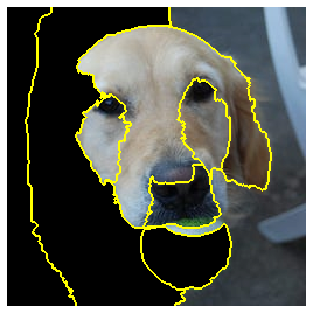

Explaining class: ->tennis ball<- (0.9419487118721008)
[[('tennis ball', 0.94194585, 852), ('Labrador retriever', 0.030055031, 208), ('golden retriever', 0.027821025, 207), ('racket', 5.08129e-05, 752), ('Chesapeake Bay retriever', 4.447031e-05, 209)]]


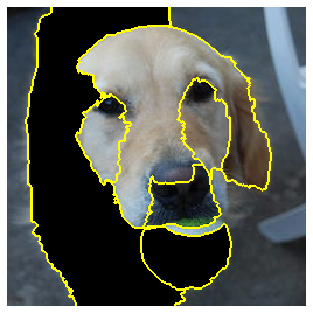

In [59]:
for idx in on_off_idxs:
    print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction[idx]})')

    # Highlight none
    if image_spec[idx]['none']:
        example_highlight = segmenter.highlight_segments(
            image_spec[idx]['none'], colour=highlight_colours['none'])
    else:
        example_highlight = segmenter.image.copy()
    # leave on
    # Occlude off
    if image_spec[idx]['off']:
        example_highlight = occluder.occlude_segments(
            image_spec[idx]['off'], image=example_highlight)
    else:
        example_highlight = example_highlight
    # highlight boundaries
    example_highlight_ = segmenter.mark_boundaries(
        image=example_highlight, colour=(255, 255, 0))

    print(clf.proba2tuple(
        clf.predict_proba([example_highlight]),
        labels_no=5
    ))

    imshow(example_highlight_)

    plt.imsave(f'_figures/explanation_limetree_multi-tree-custom{class_id}-{vis_id}.pdf',  # jpeg
               example_highlight_)